In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from swap_auditor import NaiveSwapAuditor

#### Set up data

In [121]:
nels = pd.read_csv('data/NELS_Filtered.csv')
nels_columns = pd.read_csv('data/NELS_Subset_Columns.csv')
nels_columns_readable = pd.read_csv('data/NELS_Subset_Columns_Human_Readable.csv')
nels_subset = nels[list(nels_columns.columns)]
nels_subset.columns = list(nels_columns_readable.columns)

target_col = 'GradesUndergrad'
protected_classes = ['Race', 'Sex']
id_col = 'StudentId'

#### Data helper functions

In [174]:
# Run this cell to downsample
from sklearn.utils import resample
def resample_up_down(dataframe, upsample=True, target_col=target_col):
    # Separate majority and minority classes
    df_majority = dataframe[dataframe[target_col]==1]
    df_minority = dataframe[dataframe[target_col]==0]
    
    if upsample:
        # Upsample minority class
        df_minority_upsampled = resample(df_minority, 
                                        replace=True,
                                        n_samples=len(df_majority),
                                        random_state=0)
    
        # Combine majority class with upsampled minority class
        df_resampled = pd.concat([df_majority, df_minority_upsampled])
    else:
        # Downsample majority class
        df_majority_downsampled = resample(df_majority, 
                                        replace=False,
                                        n_samples=len(df_minority),
                                        random_state=0) 
        
        # Combine minority class with downsampled majority class
        df_resampled = pd.concat([df_majority_downsampled, df_minority])
        
    # Display new class counts
    print(df_resampled[target_col].value_counts())

    return df_resampled

In [126]:
def construct_df(df_columns):
    # Only valid grades
    df = nels_subset[(1 <= nels_subset[target_col]) & (nels_subset[target_col] <= 7)]

    # Only white/black nonhispanic
    df = df[(3 <= df['Race']) & (df['Race'] <= 4)]

    # Shuffle randomly before training models
    df = df.sample(frac=1).reset_index(drop=True)

    df = df[df_columns + [target_col] + protected_classes + [id_col]]
    # Make binary decision >= 2.75 GPA
    df[target_col] = np.where(df[target_col] <= 3, 1, 0)
    make_string = False

    if make_string:
        # Make binary decision >= 2.75 GPA
        df["Race"] = np.where(df["Race"] == 3, "Black", "White")
        df["Sex"] = np.where(df["Sex"] == 1, "Male", "Female")

    df = resample_up_down(df, upsample=True, target_col=target_col)
    
    return df

In [118]:
def train_classifier(df, print_classification_report=True):
    df_train = df.copy()
    for x in protected_classes:
        df_train[x] = 0

    X = df_train[df_train.columns.difference([target_col, id_col])]
    y = df_train[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    rf = RandomForestClassifier() # max_iter=1000 
    rf.fit(x_train, y_train)

    predictions = rf.predict(x_test)

    if print_classification_report:
        print(classification_report(y_test, predictions)) # target_names=target_names

    return rf

In [119]:
def get_individual_stability(new, id):
    return new._retrieve_stability_individual(id)[0]

def construct_stability_df(df, rf, df_size, marginal_features):
    stability_df = df[:df_size]
    new = NaiveSwapAuditor(data=stability_df, predictor=rf, id_column=id_col,protected_classes=protected_classes, target_col=target_col)
    new.calculate_all_stability(marginal_features=marginal_features)
    stability_df['stability'] = stability_df.apply(lambda x: get_individual_stability(new, x.StudentId), axis=1)

    return stability_df

In [217]:
def get_stability_df(columns, marginal_features):
    df = construct_df(columns)
    rf = train_classifier(df, True)
    stability_df = construct_stability_df(df, rf, 500, marginal_features)

    df = df.drop_duplicates()
    df_predict = df[df.columns.difference([target_col] + ['StudentId'])]
    predictions_df = pd.DataFrame(rf.predict(df_predict), columns=['score'])
    df = pd.concat([df, predictions_df], axis=1)

    return df, rf, stability_df

#### Graphing functions

In [194]:
def plot_density(dfs, labels, outcome, ax):
    for i in range(len(dfs)):
        df = dfs[i]
        # print(f'rows {labels[i]}: {df.shape[0]}')
        sns.kdeplot(df[outcome], ax=ax, label=labels[i])

    ax.set_title(f'Density of {outcome} values')
    ax.set_xlabel(outcome)
    ax.legend()


In [188]:
def plot_density_by_protected_class(df, outcome):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    plot_density([df.loc[df['Sex'] == 1], df.loc[df['Sex'] == 2]], ['Male', 'Female'], outcome, ax[0])
    plot_density([df.loc[df['Race'] == 3], df.loc[df['Race'] == 4]], ['Black', 'White'], outcome, ax[1])

In [189]:
def plot_density_intersectional(df, outcome):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 5)
    plot_density([df.loc[(df['Sex'] == 1) & (df['Race'] == 3)], 
                df.loc[(df['Sex'] == 2) & (df['Race'] == 3)],
                df.loc[(df['Sex'] == 1) & (df['Race'] == 4)],
                df.loc[(df['Sex'] == 2) & (df['Race'] == 4)]], ['Black Male', 'Black Female', 'White Male', 'White Female'], outcome, ax)

In [96]:
# sex: 1 = M, 2 = F
# race: 3 = Black, 4 = white

def plot_cdf(df, feature, students, plot_index):
    y_feature = list(df[feature])
    y_feature.sort()

    bins = [x/10 for x in range(11)]
    pdf, bin_edges = np.histogram(y_feature, bins=bins)
    pdf = pdf/len(y_feature)
    cdf = np.cumsum(pdf)

    plt.subplot(plot_index)
    plt.plot(bin_edges[1:], pdf, label='PDF')
    plt.plot(bin_edges[1:], cdf, label='CDF')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'{feature} for {students} students')
    plt.legend()

In [97]:
def plot_cdfs_by_subgroup(df):
    plt.figure(figsize=(12, 8))

    plot_cdf(df.loc[df['Sex'] == 1], 'stability', 'all male', 221)
    plot_cdf(df.loc[df['Sex'] == 2], 'stability', 'all female', 222)
    plot_cdf(df.loc[df['Race'] == 3], 'stability', 'all Black', 223)
    plot_cdf(df.loc[df['Race'] == 4], 'stability', 'all white', 224)

    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)


In [98]:
def plot_cdfs_intersectional(df):
    plt.figure(figsize=(12, 8))

    plot_cdf(df.loc[(df['Sex'] == 1) & (df['Race'] == 3)], 'stability', 'all Black male', 221) 
    plot_cdf(df.loc[(df['Sex'] == 2) & (df['Race'] == 3)], 'stability', 'all Black female', 222)
    plot_cdf(df.loc[(df['Sex'] == 1) & (df['Race'] == 4)], 'stability', 'all white male', 223)
    plot_cdf(df.loc[(df['Sex'] == 2) & (df['Race'] == 4)], 'stability', 'all white female', 224)

    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

## Baseline attributes

In [218]:
baseline_columns = ['GradesMiddleSchoolEnglish',
 'GradesMiddleSchoolMath',
 'GradesMiddleSchoolScience',
 'GradesMiddleSchoolHistory',
 'CompositeGrades',
 'StandardizedTestReading',
 'StandardizedTestMath',
 'StandardizedTestScience',
 'StandardizedTestHistory',
 'StandardizedScoreReading',
 'StandardizedScoreMath',
 'StandardizedScoreScience',
 'StandardizedScoreHistory',
 'StandardizedTestQuartile',
 'StandardizedScoreReading3',
 'StandardizedScoreMath3',
 'StandardizedScoreScience3',
 'StandardizedScoreHistory3',
 'AverageGradeEnglish',
 'AverageGradeMath',
 'AverageGradeScience',
 'AverageGradeSocialStudies',
 'AverageGradeComputerScience',
 'AverageGradeForeignLanguage']
baseline_marginal_features = ['CompositeGrades', 'StandardizedTestQuartile']

baseline_df, baseline_rf, baseline_stability_df = get_stability_df(baseline_columns, baseline_marginal_features)

1    5154
0    5154
Name: GradesUndergrad, dtype: int64
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1048
           1       0.97      0.91      0.94      1014

    accuracy                           0.94      2062
   macro avg       0.94      0.94      0.94      2062
weighted avg       0.94      0.94      0.94      2062



c:\Users\Eliza\anaconda3\envs\swap_auditor_env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


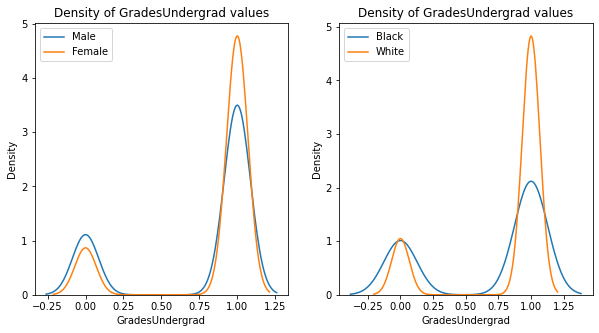

In [220]:
plot_density_by_protected_class(baseline_df, target_col)

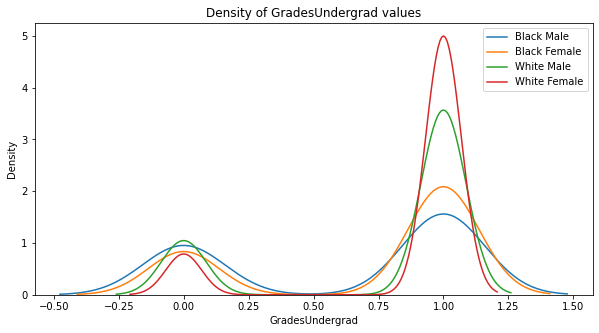

In [221]:
plot_density_intersectional(baseline_df, target_col)

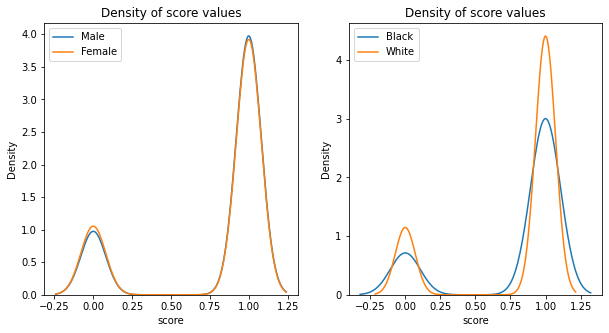

In [222]:
plot_density_by_protected_class(baseline_df, 'score')

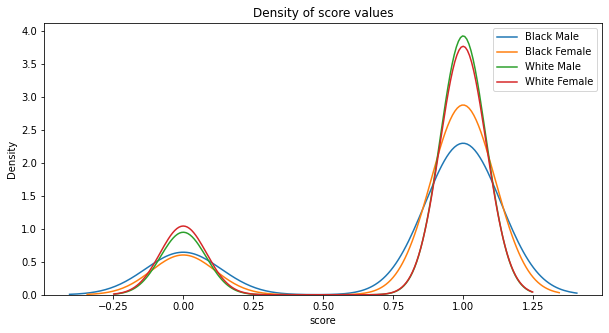

In [223]:
plot_density_intersectional(baseline_df, 'score')

## Targeted attributes

In [233]:
targeted_columns = ['CompositeGrades',
'StandardizedTestQuartile',
'CategoricalGrades',
'TimeSpentOnHomeworkInSchool',
'TimeSpentOnHomeworkOutOfSchool',
'TimeSpentOnExtracurriculars',
'ParentsCheckHomework',
'HelpWithEssays',
'HighSchoolHelpedWithSchoolApplication',
'HelpedWithFinancialAidApp',
'ParentsHighestLevelEducation',
'Socio-economicStatusQuartile',
'PrivateSchoolExpenses',
'PrivateTutoringExpenses',
'Tutored',
'FathersWishes',
'MothersWishes']
targeted_marginal_features = ['Tutored','Socio-economicStatusQuartile','FathersWishes', 'ParentsHighestLevelEducation']

targeted_df, targeted_rf, targeted_stability_df = get_stability_df(targeted_columns, targeted_marginal_features)

1    5154
0    5154
Name: GradesUndergrad, dtype: int64
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1048
           1       0.96      0.91      0.94      1014

    accuracy                           0.94      2062
   macro avg       0.94      0.94      0.94      2062
weighted avg       0.94      0.94      0.94      2062



c:\Users\Eliza\anaconda3\envs\swap_auditor_env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


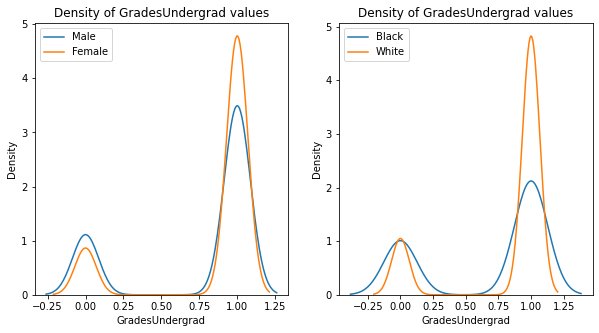

In [234]:
plot_density_by_protected_class(targeted_df, target_col)

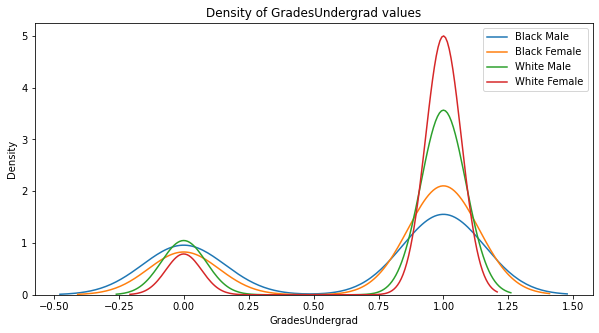

In [235]:
plot_density_intersectional(targeted_df, target_col)

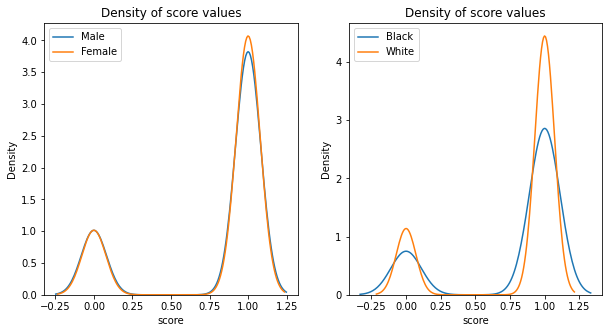

In [236]:
plot_density_by_protected_class(targeted_df, 'score')

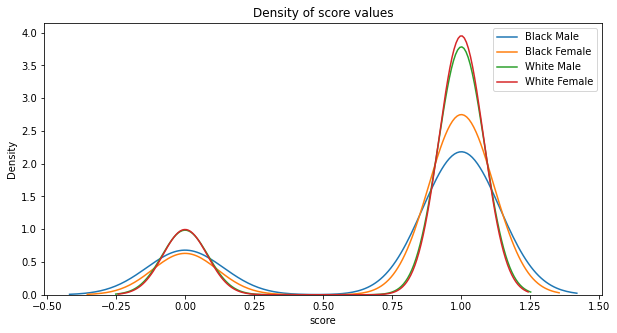

In [237]:
plot_density_intersectional(targeted_df, 'score')

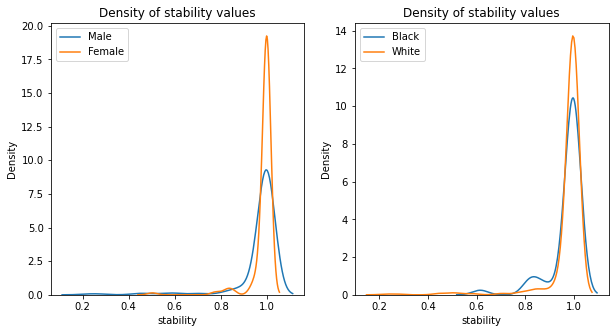

In [238]:
plot_density_by_protected_class(targeted_stability_df, 'stability')

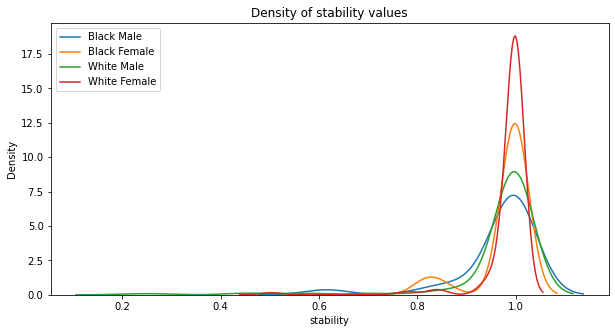

In [239]:
plot_density_intersectional(targeted_stability_df, 'stability')

## Holistic attributes

Note that any missing graphs are because the data has no variance, and in these cases stability == 1.0.

In [241]:
holistic_columns = list(nels_columns_readable.columns)
cols_to_remove = [id_col, target_col] + protected_classes
holistic_columns = [x for x in holistic_columns if x not in cols_to_remove]
holistic_marginal_features = ['Tutored','Socio-economicStatusQuartile','FathersWishes', 'ParentsHighestLevelEducation']

holistic_df, holistic_rf, holistic_stability_df = get_stability_df(holistic_columns, holistic_marginal_features)

1    5154
0    5154
Name: GradesUndergrad, dtype: int64
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1048
           1       0.97      0.97      0.97      1014

    accuracy                           0.97      2062
   macro avg       0.97      0.97      0.97      2062
weighted avg       0.97      0.97      0.97      2062



c:\Users\Eliza\anaconda3\envs\swap_auditor_env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


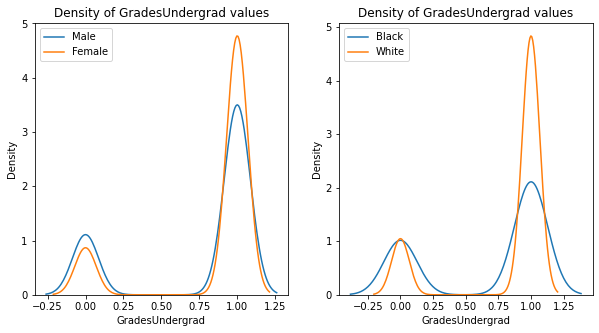

In [242]:
plot_density_by_protected_class(holistic_df, target_col)

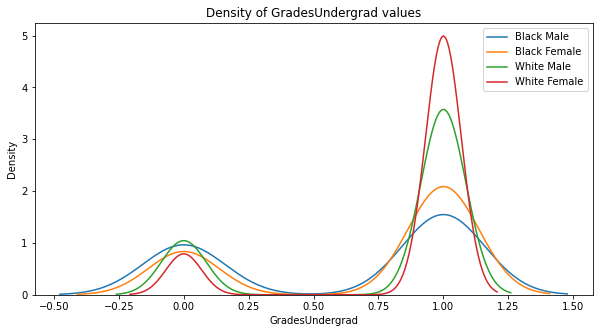

In [243]:
plot_density_intersectional(holistic_df, target_col)

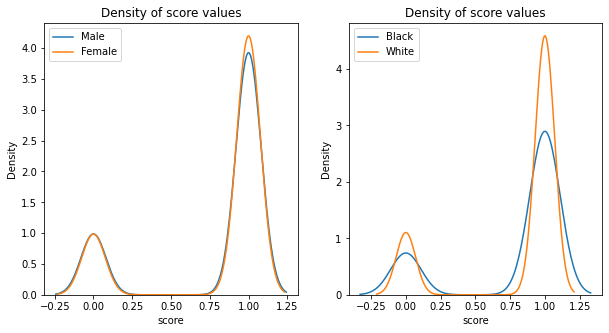

In [244]:
plot_density_by_protected_class(holistic_df, 'score')

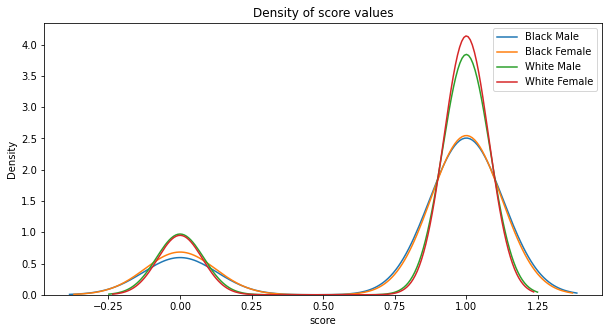

In [246]:
plot_density_intersectional(holistic_df, 'score')

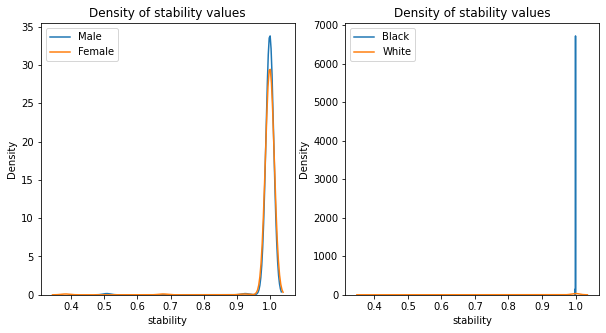

In [245]:
plot_density_by_protected_class(holistic_stability_df, 'stability')

c:\Users\Eliza\anaconda3\envs\swap_auditor_env\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
c:\Users\Eliza\anaconda3\envs\swap_auditor_env\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


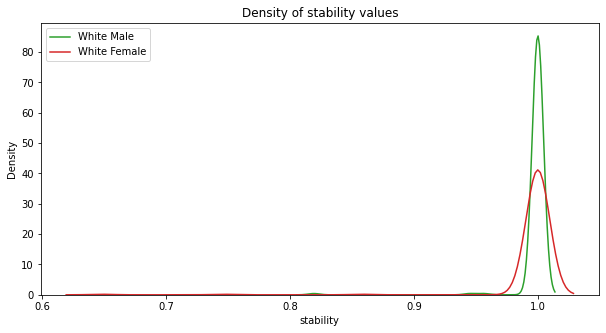

In [ ]:
plot_density_intersectional(holistic_stability_df, 'stability')

### Comparing distributions of features based on inflection points in stability

In [85]:
def plot_stability_cdfs(df):
    plt.figure(figsize=(12, 8))

    plot_cdf(df.loc[df['Race'] == 3], 'stability', 'all Black', 221)
    plot_cdf(df.loc[df['Race'] == 4], 'stability', 'all white', 222)

    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)


In [86]:
def plot_features(black_under, black_over, white_over, features, stability_inflection):
    for i in range(len(features)):
        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches(10, 5)
        feature = features[i]

        axs = ax[0]
        sns.kdeplot(black_under[feature], ax=axs, label=f'Black (stability < {stability_inflection})')
        sns.kdeplot(white_over[feature], ax=axs, label=f'White (stability >= {stability_inflection})')
        axs.set_title('Synth ('+str(feature)+')')
        axs.set_xlabel('Outcomes')
        axs.legend()

        axs = ax[1]
        sns.kdeplot(black_over[feature], ax=axs, label=f'Black (stability >= {stability_inflection})')
        sns.kdeplot(white_over[feature], ax=axs, label=f'White (stability >= {stability_inflection})')
        axs.set_title('Synth ('+str(feature)+')')
        axs.set_xlabel('Outcomes')
        axs.legend()
    

c:\Users\Eliza\anaconda3\envs\swap_auditor_env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


TypeError: plot_features() missing 2 required positional arguments: 'features' and 'stability_inflection'

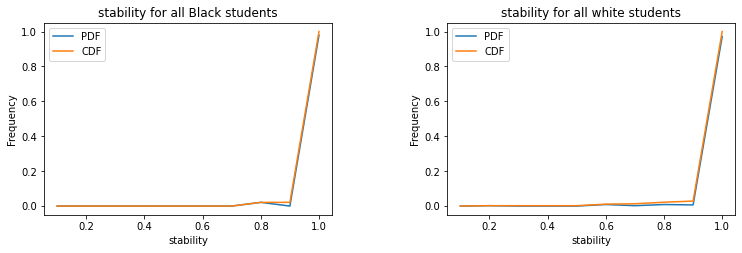

In [87]:
import itertools
marginal_features_all= ['Tutored','Socio-economicStatusQuartile', 'FathersWishes']
marginal_features = list(itertools.combinations(marginal_features_all, 2))

df_black_under = set()
df_white_over = set()
stability_inflection = 1
for marg_pair in marginal_features:
    df = construct_df(marg_pair)
    black_under = df[(df['Race'] == 3) & (df['stability'] < stability_inflection)]
    black_over = df[(df['Race'] == 3) & (df['stability'] >= stability_inflection)]
    white_over = df[(df['Race'] == 4) & (df['stability'] >= stability_inflection)]

    df_black_under.update(list(black_under['StudentId']))
    df_white_over.update(list(white_over['StudentId']))

    plot_stability_cdfs(df)
    plot_features(df, marg_pair, stability_inflection)

In [ ]:
print(f'Black students with stability < {stability_inflection}: {len(df_black_under)}')
print(f'White students with stability >= {stability_inflection}: {len(df_white_over)}')

Black students with stability < 1: 5
White students with stability >= 1: 438


In [ ]:
tiny_test

,StudentId,Sex,Race,CompositeGrades,StandardizedTestQuartile,CategoricalGrades,TimeSpentOnHomeworkInSchool,TimeSpentOnHomeworkOutOfSchool,TimeSpentOnExtracurriculars,HelpWithEssays,...,HelpedWithFinancialAidApp,ParentsHighestLevelEducation,Socio-economicStatusQuartile,PrivateSchoolExpenses,PrivateTutoringExpenses,Tutored,FathersWishes,MothersWishes,GradesUndergrad,stability
0,7210080,2,3,3.0,2,99,3,2,2,2,...,1,3,2,2,2,-9,5,5,1,0.997859
1,2504417,1,4,4.0,4,99,1,2,1,1,...,2,2,1,1,2,-9,5,5,1,1.000000
2,719429,2,4,3.0,2,99,3,2,4,2,...,2,3,2,2,2,-9,3,3,1,1.000000
3,2479643,2,4,2.8,2,99,1,1,0,2,...,2,3,2,2,2,-9,5,5,1,0.939723
4,7850443,1,4,2.8,3,99,3,1,2,2,...,1,2,1,2,2,-9,5,5,1,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,702866,1,4,4.0,4,99,1,3,0,2,...,2,2,2,8,8,-9,3,4,1,1.000000
645,4533012,1,3,3.0,3,99,2,6,0,1,...,1,3,3,2,2,-9,5,5,1,1.000000
646,7212837,1,4,2.8,3,99,1,1,0,1,...,2,3,1,2,2,-9,3,5,1,0.878479
647,2506403,2,4,3.0,3,99,1,2,4,2,...,2,5,4,2,2,-9,6,5,1,1.000000


In [ ]:
df_subset = tiny_test[tiny_test['StudentId'].isin(df_black_under)]
df_subset[['Tutored','Socio-economicStatusQuartile', 'FathersWishes']]
make_df_human_readable(df_subset)

/var/folders/qj/gh_j11514m37mqtfrlr885k40000gn/T/ipykernel_68225/3494390913.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(str)


,StudentId,Sex,Race,CompositeGrades,StandardizedTestQuartile,CategoricalGrades,TimeSpentOnHomeworkInSchool,TimeSpentOnHomeworkOutOfSchool,TimeSpentOnExtracurriculars,HelpWithEssays,...,HelpedWithFinancialAidApp,ParentsHighestLevelEducation,Socio-economicStatusQuartile,PrivateSchoolExpenses,PrivateTutoringExpenses,Tutored,FathersWishes,MothersWishes,GradesUndergrad,stability
289,6819460,Female,"Black, not Hispanic",1.3,QUARTILE 1 LOW,99,7-9 hours,7-9 hours,None,No,...,No,> HS and < 4 year degree,QUARTILE 2,No,Yes,Missing,Graduate from college,Graduate from college,1,0.8182930559804221
314,7277499,Female,"Black, not Hispanic",2.3,QUARTILE 3,99,1 hour or less,2-3 hours,None,No,...,No,HS grad or GED,QUARTILE 3,No,No,Missing,Graduate from college,Graduate from college,1,0.9761394921994494
352,2507109,Male,"Black, not Hispanic",2.5,QUARTILE 2,99,1 hour or less,2-3 hours,None,Yes,...,No,> HS and < 4 year degree,QUARTILE 3,No,No,Missing,Don't know,Don't know,1,0.8826112412177985
522,7217019,Female,"Black, not Hispanic",1.8,QUARTILE 4 HIGH,99,None,4-6 hours,5-9 hours per week,Yes,...,No,HS grad or GED,QUARTILE 3,Yes,No,Missing,Attend college,Attend college,1,0.9311716121137963
633,6849422,Male,"Black, not Hispanic",9.9,QUARTILE 1 LOW,99,2-3 hours,4-6 hours,None,No,...,No,99,QUARTILE 3,No,No,Missing,99,99,1,0.9976580796252927


In [ ]:
df_subset = tiny_test[tiny_test['StudentId'].isin(df_white_over)]
df_subset[['Tutored','Socio-economicStatusQuartile', 'FathersWishes']]
make_df_human_readable(df_subset)

/var/folders/qj/gh_j11514m37mqtfrlr885k40000gn/T/ipykernel_68225/3494390913.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(str)


,StudentId,Sex,Race,CompositeGrades,StandardizedTestQuartile,CategoricalGrades,TimeSpentOnHomeworkInSchool,TimeSpentOnHomeworkOutOfSchool,TimeSpentOnExtracurriculars,HelpWithEssays,...,HelpedWithFinancialAidApp,ParentsHighestLevelEducation,Socio-economicStatusQuartile,PrivateSchoolExpenses,PrivateTutoringExpenses,Tutored,FathersWishes,MothersWishes,GradesUndergrad,stability
1,2504417,Male,"White, not Hispanic",4.0,QUARTILE 4 HIGH,99,1 hour or less,2-3 hours,1 hour or less per week,Yes,...,No,HS grad or GED,QUARTILE 1 LOW,Yes,No,Missing,Graduate from college,Graduate from college,1,1.0
2,719429,Female,"White, not Hispanic",3.0,QUARTILE 2,99,4-6 hours,2-3 hours,10-19 hours per week,No,...,No,> HS and < 4 year degree,QUARTILE 2,No,No,Missing,"Vocational, trade, after high school","Vocational, trade, after high school",1,1.0
3,2479643,Female,"White, not Hispanic",2.8,QUARTILE 2,99,1 hour or less,1 hour or less,None,No,...,No,> HS and < 4 year degree,QUARTILE 2,No,No,Missing,Graduate from college,Graduate from college,1,0.9397227245328511
4,7850443,Male,"White, not Hispanic",2.8,QUARTILE 3,99,4-6 hours,1 hour or less,1-4 hours per week,No,...,Yes,HS grad or GED,QUARTILE 1 LOW,No,No,Missing,Graduate from college,Graduate from college,1,1.0
5,790211,Female,"White, not Hispanic",3.3,QUARTILE 4 HIGH,99,4-6 hours,7-9 hours,1 hour or less per week,No,...,No,Masters / Equivalent,QUARTILE 3,No,No,Missing,Graduate from college,Graduate from college,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,7279221,Female,"White, not Hispanic",2.8,QUARTILE 4 HIGH,99,4-6 hours,Over 15 hours,1 hour or less per week,School doesn't have,...,No,Didn't finish HS,QUARTILE 1 LOW,No,No,Missing,Don't know,Graduate from college,1,1.0
644,702866,Male,"White, not Hispanic",4.0,QUARTILE 4 HIGH,99,1 hour or less,4-6 hours,None,No,...,No,HS grad or GED,QUARTILE 2,Missing,Missing,Missing,"Vocational, trade, after high school",Attend college,1,1.0
646,7212837,Male,"White, not Hispanic",2.8,QUARTILE 3,99,1 hour or less,1 hour or less,None,Yes,...,No,> HS and < 4 year degree,QUARTILE 1 LOW,No,No,Missing,"Vocational, trade, after high school",Graduate from college,1,0.87847866419295
647,2506403,Female,"White, not Hispanic",3.0,QUARTILE 3,99,1 hour or less,2-3 hours,10-19 hours per week,No,...,No,Masters / Equivalent,QUARTILE 4 HIGH,No,No,Missing,Higher school after college,Graduate from college,1,1.0
